In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import pydotplus
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
import graphviz
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
warnings.simplefilter(action="ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# keşifçi veri analizi için:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# kategorik değişken özetleme
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

# numerik değişken özetleme
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

# bağımlı değişkeni sayısal değişken ile özetleme
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

# bağımlı değişkeni kategorik değişken ile özetleme
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

# korelasyon matrisini oluşturma
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

# kategorik, numerik, numerik görünümlü kategorik ve kategorik ama kardinal değişkenleri düzenleme
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car

def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], color="g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

# aykırı değer üst ve alt limitlerini bulma
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# aykırı değerleri üst ve alt limitler ile değiştirme
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# aykırı gözlem var mı diye bakma
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# eksik değerleri bulmak için
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi    
def missing_vs_target(dataframe, target, na_columns): 
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

# one hot encoder işlemi yani kategorikleri 0 ve 1 düzenine geçirme
# kullanırken drop_first = True olmalı ki dummy değişken tuzağına takılmayalım
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# tüm modeller için sonuçları inceleyebilmek için base_model fonksiyonu:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

# en iyi modeli kurmak için gerekli olan hiperparametreleri bulmak için:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

# en iyi parametrelerle en uygun sınıflandırma yöntemini bulma
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

def highCorrelatedCols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    corMatrix = corr.abs()
    upperTriangleMatrix = corMatrix.where(np.triu(np.ones(corMatrix.shape), k=1).astype(bool))
    dropList = [col for col in upperTriangleMatrix.columns if any(upperTriangleMatrix[col] > 0.90)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return dropList

In [3]:
df = pd.read_csv('/content/drive/MyDrive/NetworkAnomalyDataset.csv', low_memory = False, nrows= 1000000)

 IP , UNNAMED gibi gereksiz kolonları eledim

In [4]:
df = df.iloc[:,9:-8] 

In [6]:
df.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count',


Verileri kategorik, numerik ve kategorik ama kardinal olarak ayırdım

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20) 

Kategorik verileri inceledim

In [6]:
for col in cat_cols:
    cat_summary(df, col) 

             Label  Ratio
BENIGN      502622 50.262
DrDoS_SNMP  199102 19.910
DrDoS_DNS   198547 19.855
DDoS         99729  9.973
##########################################
   Fwd PSH Flags  Ratio
0         971733 97.173
1          28267  2.827
##########################################
    Bwd PSH Flags   Ratio
0         1000000 100.000
##########################################
    Fwd URG Flags  Ratio
0          999930 99.993
1              70  0.007
##########################################
    Bwd URG Flags   Ratio
0         1000000 100.000
##########################################
   FIN Flag Count  Ratio
0          975384 97.538
1           24616  2.462
##########################################
    SYN Flag Count  Ratio
0           971803 97.180
1            28197  2.820
##########################################
    RST Flag Count  Ratio
0           999755 99.975
1              245  0.025
##########################################
    PSH Flag Count  Ratio
0           847354

Çoğu kolon tek bir tür veri içerdiği için bu kolonları elemeye karar verdim 
' Label' ve ' ACK Flag Count' kolonları hariç

In [7]:
cat_cols.remove(' Label')
cat_cols.remove(' ACK Flag Count')

In [8]:
df.drop(cat_cols, axis = 1, inplace = True)

In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

KOlonlarda boş değer var mı buna bakmak istedim ve Flow Bytes/s kolonunda boşluk olduğunu gördüm

In [10]:
df.isna().sum()

 Flow Duration                    0
 Total Fwd Packets                0
 Total Backward Packets           0
Total Length of Fwd Packets       0
 Total Length of Bwd Packets      0
 Fwd Packet Length Max            0
 Fwd Packet Length Min            0
 Fwd Packet Length Mean           0
 Fwd Packet Length Std            0
Bwd Packet Length Max             0
 Bwd Packet Length Min            0
 Bwd Packet Length Mean           0
 Bwd Packet Length Std            0
Flow Bytes/s                    343
 Flow Packets/s                   0
 Flow IAT Mean                    0
 Flow IAT Std                     0
 Flow IAT Max                     0
 Flow IAT Min                     0
Fwd IAT Total                     0
 Fwd IAT Mean                     0
 Fwd IAT Std                      0
 Fwd IAT Max                      0
 Fwd IAT Min                      0
Bwd IAT Total                     0
 Bwd IAT Mean                     0
 Bwd IAT Std                      0
 Bwd IAT Max                

Kolonu ve veriyi bozmamak için kolonun ortalama değerlerin boş değerler yerine atadım

In [11]:
df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].median(), inplace=True)

Kolonlarda aykırı değerler varmı bunlara baktım. (alt limit = 0.05, üst limit = 0.95)

Aykırı değerleri üst ve alt limitler ile değiştirdim.

In [13]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

 Flow Duration False
 Total Fwd Packets True
 Total Backward Packets True
Total Length of Fwd Packets True
 Total Length of Bwd Packets True
 Fwd Packet Length Max True
 Fwd Packet Length Min False
 Fwd Packet Length Mean True
 Fwd Packet Length Std True
Bwd Packet Length Max True
 Bwd Packet Length Min True
 Bwd Packet Length Mean False
 Bwd Packet Length Std True
Flow Bytes/s True
 Flow Packets/s True
 Flow IAT Mean True
 Flow IAT Std True
 Flow IAT Max False
 Flow IAT Min True
Fwd IAT Total False
 Fwd IAT Mean True
 Fwd IAT Std True
 Fwd IAT Max False
 Fwd IAT Min True
Bwd IAT Total False
 Bwd IAT Mean True
 Bwd IAT Std True
 Bwd IAT Max True
 Bwd IAT Min True
 Fwd Header Length True
 Bwd Header Length True
Fwd Packets/s False
 Bwd Packets/s True
 Min Packet Length False
 Max Packet Length True
 Packet Length Mean False
 Packet Length Std True
 Packet Length Variance True
 Down/Up Ratio True
 Average Packet Size False
 Avg Fwd Segment Size True
 Avg Bwd Segment Size False
 Fwd Heade

In [14]:
check_outlier(df,num_cols) #aykiri deger var mi

False

kolonların düzenli durması için hepsini büyük ve boşluklar yerine alt çizgi koydum.

In [15]:
df.columns = [col.upper() for col in df.columns]

In [16]:
df.columns = [i.replace(' ', '_') for i in df.columns]

tekrardan verileri ayırıp inceledim.

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

In [18]:
for col in cat_cols:
    cat_summary(df, col)

            _LABEL  Ratio
BENIGN      502622 50.262
DrDoS_SNMP  199102 19.910
DrDoS_DNS   198547 19.855
DDoS         99729  9.973
##########################################
   _ACK_FLAG_COUNT  Ratio
0           794223 79.422
1           205777 20.578
##########################################
       _DOWN/UP_RATIO  Ratio
0.000          637068 63.707
1.000          344519 34.452
2.000           12243  1.224
2.500            6170  0.617
##########################################
       _ACTIVE_STD   Ratio
0.000      1000000 100.000
##########################################


In [19]:
df.drop(['_ACTIVE_STD'],axis = 1, inplace = True)

In [20]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

numerik kolonlar için korelasyon matrisine baktım.

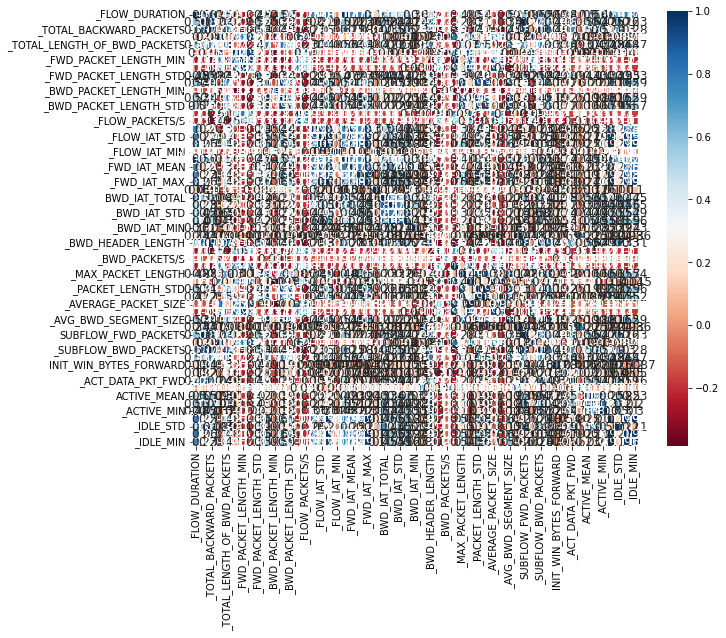

In [21]:
correlation_matrix(df, num_cols) #korelasyon matrisi

Korelasyon matrisine göre iki kolon arasındaki değer yüzde 90 nın üzerindeyse bu kolonlar aynı şeyi temsil ettiği için birini eledim.

In [22]:
corr = df[num_cols].corr()  # korelasyon matrisi oluşturma

In [23]:
corMatrix = df.corr().abs()

In [24]:
upperTriangleMatrix = corMatrix.where(np.triu(np.ones(corMatrix.shape), k=1).astype(bool))
drop_list = [col for col in upperTriangleMatrix.columns if any(upperTriangleMatrix[col]>0.90) ]
df.drop(drop_list, axis=1, inplace = True)

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

Standart scaler uyguladım 0-1 aralığında

In [26]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [27]:
y = df['_LABEL']
x = df.drop(["_LABEL"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=0)

In [32]:
enc = OneHotEncoder(handle_unknown ='ignore')
y = y.values.reshape(-1,1)
y = enc.fit_transform(y).toarray()

kategorik verilere onehotencoder uyguladım

Overfittingi en az seviyeye indirmek için training's multi_logloss değerleri kullandım gittikçe azalıyordu fakat 920 den sonra 8 gibi bir değere fırladığı için optimum olarak 900 aldım geriye kalan parametreleri daha önce çizdirdiğim grafiklere göre Tradition score ve Validation score aralığını mümkün oldukça az olan değerleri seçtim

In [33]:
model = lgb.LGBMClassifier(learning_rate=0.05,max_depth=5,n_estimators=900,colsample_bytree=0.800,random_state=0)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's multi_logloss: 0.462686	training's multi_logloss: 0.462686	valid_0's multi_logloss: 0.462968	valid_0's multi_logloss: 0.462968
[40]	training's multi_logloss: 0.260306	training's multi_logloss: 0.260306	valid_0's multi_logloss: 0.260108	valid_0's multi_logloss: 0.260108
[60]	training's multi_logloss: 0.185367	training's multi_logloss: 0.185367	valid_0's multi_logloss: 0.184968	valid_0's multi_logloss: 0.184968
[80]	training's multi_logloss: 0.153705	training's multi_logloss: 0.153705	valid_0's multi_logloss: 0.153274	valid_0's multi_logloss: 0.153274
[100]	training's multi_logloss: 0.138677	training's multi_logloss: 0.138677	valid_0's multi_logloss: 0.138376	valid_0's multi_logloss: 0.138376
[120]	training's multi_logloss: 0.129873	training's multi_logloss: 0.129873	valid_0's multi_logloss: 0.129655	valid_0's multi_logloss: 0.129655
[140]	training's multi_logloss: 0.124356	training's multi_logloss: 0.124356	valid_0's multi_logloss: 0.124276	valid_0's multi_logloss: 0.124

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
               n_estimators=900, random_state=0)

Train ve Test arasında çok ciddi bir fark yok bu iyi bir şey

In [34]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.9630
Testing accuracy 0.9627


LGB nin fonksiyonunu kullanarak Kolonları önem sıralamasına göre dizdim. Burada en alttaki bazı kolonları eleyebiliriz.

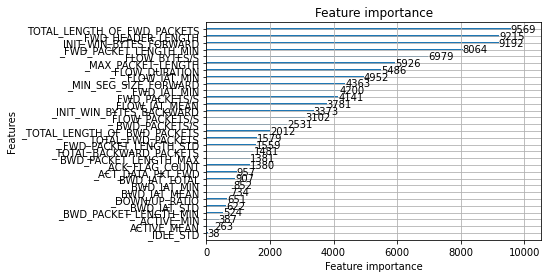

In [35]:
lgb.plot_importance(model)

traning ve valid değeri ayrıldığı yerde overfitting yapmaya başlar ama burada üst üste gidiyorlar değerler birbirine çok yakın

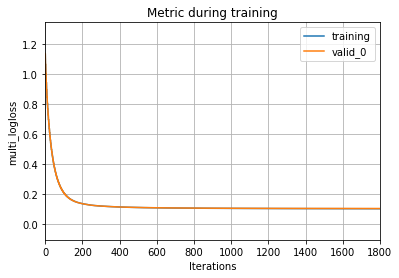

In [36]:
lgb.plot_metric(model)

In [37]:
# predict the results
y_pred= model.predict(x_test)

In [38]:
"""

Confusion matrix ve Vlassification report a göre Benign ve Ddos ezberlenmiş gibi geliyor ama DNS ve SNMP değerleri %91 oranında doğru tahmin ediliyor.

                  CONFUSİON MATRİX

             BENIGN   DDoS  DrDoS_DNS  DrDoS_SNMP
BENIGN      [200528     69       4        1]
DDoS        [    23  40074       0        0]
DrDoS_DNS   [    16      0   72058     7390]
DrDoS_SNMP  [     3      0    7403    72431]

"""

'\n\nConfusion matrix ve Vlassification report a göre Benign ve Ddos ezberlenmiş gibi geliyor ama DNS ve SNMP değerleri %91 oranında doğru tahmin ediliyor.\n\n                  CONFUSİON MATRİX\n\n             BENIGN   DDoS  DrDoS_DNS  DrDoS_SNMP\nBENIGN      [200528     69       4        1]\nDDoS        [    23  40074       0        0]\nDrDoS_DNS   [    16      0   72058     7390]\nDrDoS_SNMP  [     3      0    7403    72431]\n\n'

In [39]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[200528     69      4      1]
 [    23  40074      0      0]
 [    16      0  72058   7390]
 [     3      0   7403  72431]]


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    200602
        DDoS       1.00      1.00      1.00     40097
   DrDoS_DNS       0.91      0.91      0.91     79464
  DrDoS_SNMP       0.91      0.91      0.91     79837

    accuracy                           0.96    400000
   macro avg       0.95      0.95      0.95    400000
weighted avg       0.96      0.96      0.96    400000



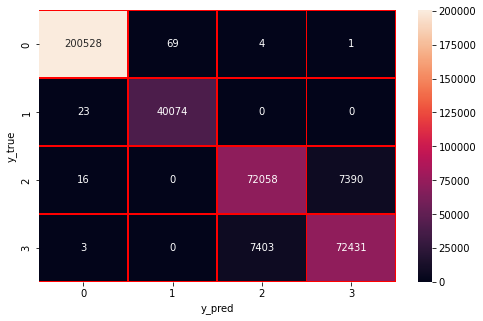

In [41]:
f, ax = plt.subplots(figsize =(8,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

En iyi LGBM parametlerini alabilmek için grafikleri kontrol ettim

In [29]:
lgbm_model_ = LGBMClassifier()

In [30]:
lightgbm_params2 = [["learning_rate", [0.01, 0.1]],["n_estimators", [200, 300, 500]], ['max_depth', range(1, 20)], ["colsample_bytree", [0.9, 0.8, 1]]]

In [31]:
for i in range(len(lightgbm_params2)):
    val_curve_params(lgbm_model_, x, y, lightgbm_params2[i][0], lightgbm_params2[i][1], scoring="accuracy")

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
kf=KFold(n_splits=5)

In [ ]:
score=cross_val_score(lgbm_model_,x,y,cv=kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Base model fonksiyonuyla en iyi accuracy veren algoritmaya bakılabilir.

In [ ]:
base_models(x, y, scoring="accuracy")

In [ ]:
######################################################
# 4. Automated Hyperparameter Optimization
######################################################

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [200,300, 500],
                   "max_depth": range(1, 20), 
                   "colsample_bytree": [0.9, 0.8, 1]}
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

hyperparameter_optimization fonksiyonu ile algoritmalar için en iyi parametreler seçilebilir.

In [ ]:
best_models = hyperparameter_optimization(x, y)

In [70]:
random_user = df.sample(100000, random_state=0)

In [71]:
random_y = random_user['_LABEL']
random_x = random_user.drop(["_LABEL"], axis=1)

In [72]:
random_pred = model.predict(random_x)

In [77]:
print("Accuracy: {}".format(model.score(random_x, random_y)))

Accuracy: 0.96223


In [73]:
cm = confusion_matrix(random_y, random_pred)
print(cm)

[[50281    16     1     0]
 [    5  9998     0     0]
 [    5     0 18045  1893]
 [    0     0  1857 17899]]


In [74]:
from sklearn.metrics import classification_report
print('Classification report: \n',classification_report(random_y,random_pred))

Classification report: 
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     50298
        DDoS       1.00      1.00      1.00     10003
   DrDoS_DNS       0.91      0.90      0.91     19943
  DrDoS_SNMP       0.90      0.91      0.91     19756

    accuracy                           0.96    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.96      0.96      0.96    100000

